In [1]:
from tqdm import tqdm
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import segmentation_models_pytorch as smp
from torchvision.utils import make_grid, save_image

import model
import metrics
import config
import utis

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from dataset import HistoricalImagesDataset
import config
import glob

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb

In [2]:
# Paths
IMAGES_PATH = '../data/patches/images/1942'
MASK_PATH = '../data/patches/masks/1942'
BEST_MODEL = '../best_model'
# PREDICTIONS_PATH = 

image_paths = glob.glob(IMAGES_PATH +'/*.tif')
mask_paths = glob.glob(MASK_PATH +'/*.tif')

### Weights and Biases

In [3]:
!wandb login

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


### Dataloader

In [3]:
# Dataset Object 
print('Number of image patches:', len(image_paths),'\nNumber of mask patches:', len(mask_paths))
dataset = HistoricalImagesDataset(image_paths, mask_paths)
data = next(iter(dataset))
print('shape image', data[0].shape, 'shape mask', data[1].shape)       

# Train, Test, Split -- DEVEOLP A SPLITTING STRATEGY BASED ON THE SPATIAL INFORMATION !!!!!!!!!
print('Splitting data into TRAIN, VAL and TEST')
train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) #-- pytorch alternative to the train_test_split command line from Scikit-Learn

train_size = int(0.5 * len(train_dataset))
val_size = len(train_dataset) - train_size
test_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader
print("Training set size: ", len(train_dataset))
train_dataloader = DataLoader(dataset=train_dataset, batch_size = config.BATCH_SIZE)
print("Validation set size: ", len(val_dataset))
val_dataloader = DataLoader(dataset=val_dataset, batch_size = config.BATCH_SIZE)
print("Testing set size: ", len(test_dataset))
test_dataloader = DataLoader(dataset=test_dataset, batch_size = config.BATCH_SIZE)

Number of image patches: 3484 
Number of mask patches: 3484
shape image torch.Size([1, 256, 256]) shape mask torch.Size([1, 256, 256])
Splitting data into TRAIN, VAL and TEST
Training set size:  1742
Validation set size:  871
Testing set size:  871


In [8]:
train_dataloader

AttributeError: 'DataLoader' object has no attribute 'shape'

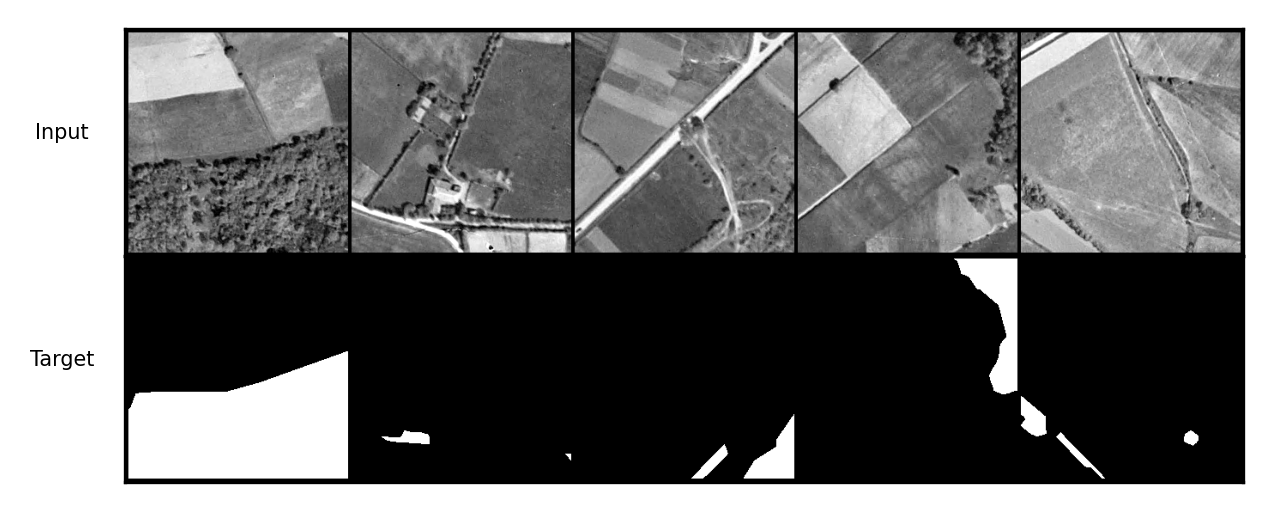

In [4]:
val_dataloader_iter = iter(val_dataloader)
grids = utis.create_segement_grids(val_dataloader_iter)
utis.plot_grids(grids)

### Check if CUDA is available

In [6]:
config.DEVICE

'cuda'

### Training

In [7]:
def train(model, dataloader, optim, lossFunc, epoch, scaler):
    # set the model in training mode
    model.train()

    # Save total train loss
    totalTrainLoss = 0
    
    # metrics
    accuracy = 0
    iou = 0
    f1score = 0
    
    # loop over the training set
    loop = tqdm(dataloader, leave=False)
    for x, y in loop:
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.float().to(config.DEVICE))
        
        # forward with autocast        
        with autocast():
            pred = model(x)
            loss = lossFunc(pred, y)
            
        optim.zero_grad()  # zero out any previously accumulated gradients    
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        
        totalTrainLoss += loss  # add the loss to the total training loss so far 

#         # forward
#         # with torch.cuda.amp.autocast(): # setting float16 to speed up the traiing
#         pred = model(x)
#         loss = lossFunc(pred, y)
        
#         optim.zero_grad()  # zero out any previously accumulated gradients
#         loss.backward() # obtain the gradients with respect to the loss
#         optim.step() # perform one step of gradient descendent
#         totalTrainLoss += loss  # add the loss to the total training loss so far 
        
        # metrics      
        all_metrics = metrics.metrics(pred, y)
        accuracy += all_metrics['acc']
        iou += all_metrics['iou']
        f1score += all_metrics['f1score']
        
        # update tqdm
        loop.set_description(f'Training Epoch [{epoch}/{config.NUM_EPOCHS}]')
        loop.set_postfix(loss=loss.item(), acc = all_metrics['acc'], iou=all_metrics['iou'])
        
    # calculate the average training loss PER EPOCH
    avgTrainLoss = totalTrainLoss / len(dataloader)
    avgAccLoss = accuracy / len(dataloader)
    avgIOU = iou / len(dataloader)
    avgF1score = f1score / len(dataloader)
    
    ## update training history
    training_history["avg_train_loss"].append(avgTrainLoss.cpu().detach().numpy()) # save the avg loss
    training_history["train_accuracy"].append(avgAccLoss) # save the acc 
    training_history["IoU"].append(avgIOU) # save the iou
    training_history["f1score"].append(avgF1score) # save the f1score
    
    # WANDB
    wandb.log({
    # "Examples": example_images,
    "Train Loss": avgTrainLoss,
    "Train Accuracy": avgAccLoss,
    "IoU_train":avgIOU})
    
    return training_history

In [8]:
def validation(model, dataloader, lossFunc, epoch):
    # Save total train loss
    totalValLoss = 0
    
    # metrics
    accuracy_val = 0
    iou_val = 0
    f1score_val = 0
    
    iter_ = 1
    # switch off autograd
    with torch.no_grad():
    # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        loop = tqdm(dataloader, leave=False)
        for (x_val, y_val) in loop:
            # send the input to the device
            (x_val, y_val) = (x_val.to(config.DEVICE), y_val.to(config.DEVICE))
            
            # make the predictions and calculate the validation loss
            pred_val = model(x_val)
            loss = lossFunc(pred_val, y_val)
            totalValLoss += loss
            
            # metrics      
            all_metrics = metrics.metrics(pred_val, y_val)
            accuracy_val += all_metrics['acc']
            iou_val += all_metrics['iou']
            f1score_val += all_metrics['f1score']
            
            # Plotting Val 
            # if iter_  % 2 == 0: # plot every time iter is a multiple of 2
            # utis.plot_comparison(x_val, pred_val, y_val)
            # iter_ += 1 
            
            # update tqdm
            loop.set_description(f'Validation Epoch [{epoch}/{config.NUM_EPOCHS}]')
            loop.set_postfix(loss_val=loss.item(), acc_val = all_metrics['acc'], iou_val=all_metrics['iou'])

                        
    # calculate the average VALIDATION loss PER EPOCH
    avgValLoss = totalValLoss / len(dataloader)
    avgAccLoss = accuracy_val / len(dataloader)
    avgIOU = iou_val / len(dataloader)
    avgF1score = f1score_val / len(dataloader)

    ## update VALIDATION history
    validation_history["avg_val_loss"].append(avgValLoss.cpu().detach().numpy()) # save the avg loss
    validation_history["val_accuracy"].append(avgAccLoss) # save the acc
    validation_history["IoU_val"].append(avgIOU) # save the iou
    validation_history["f1score_val"].append(avgF1score) # save the iou
    
    # WANDB
    wandb.log({
    # "Examples": example_images,
    "Val Accuracy": avgAccLoss,
    "Val Loss": avgValLoss,
    "IoU_val": avgIOU})
    
    return validation_history

### MAIN

In [9]:
# WandB – Initialize a new run
wandb.init(entity="vibferreira", project="master_thesis")

# Initialize our model
unet = model.unet_model.to(config.DEVICE)

# initialize loss function and optimizer
lossFunc = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
opt = optim.Adam(unet.parameters(), lr=config.LR)

# initialize a dictionary to store TRAINING history (keep track on training)
training_history = {"avg_train_loss": [], "train_accuracy": [], "IoU":[],"f1score":[]}

# # initialize a dictionary to store VALIDATION history (keep track on VALIDATION)
validation_history = {"avg_val_loss": [], "val_accuracy": [], "IoU_val":[], "f1score_val":[]}

# Using log="all" log histograms of parameter values in addition to gradients
# wandb.watch(unet, log="all")

# Autocasting 
scaler = GradScaler()

# initialize best accuracy
best_accuracy = 0.0
print(f'''Training the network for {config.NUM_EPOCHS} epochs, with a batch size of {config.BATCH_SIZE}''') # try with logger

# loop = tqdm(range(config.NUM_EPOCHS))
for e in range(config.NUM_EPOCHS):
    trained = train(unet, train_dataloader, opt, lossFunc, epoch=e, scaler=scaler)
    validated = validation(unet, val_dataloader, lossFunc, epoch=e)
    
    # Save best model
    if validated['val_accuracy'][-1] > best_accuracy : # maybe add a minimum number of epochs as conditions
        utis.save_best_model(unet, BEST_MODEL, validated, e)
        best_accuracy = validation_history['val_accuracy'][-1]

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


Training the network for 10 epochs, with a batch size of 16


### Predictions

  0%|                                                    | 0/55 [00:00<?, ?it/s]

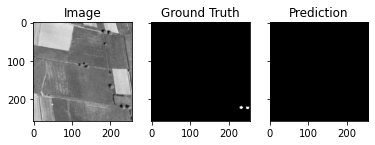

  2%|▊                                           | 1/55 [00:02<01:57,  2.18s/it]

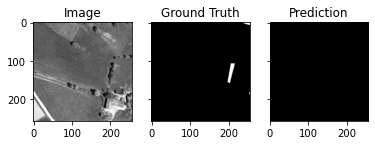

  4%|█▌                                          | 2/55 [00:02<01:10,  1.34s/it]

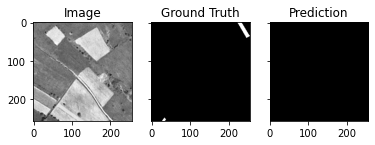

  5%|██▍                                         | 3/55 [00:03<00:55,  1.08s/it]

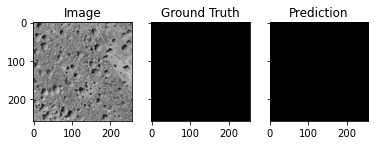

  7%|███▏                                        | 4/55 [00:04<00:47,  1.07it/s]

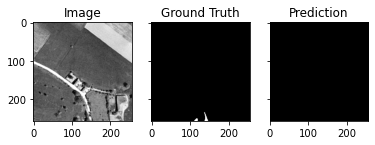

  9%|████                                        | 5/55 [00:05<00:48,  1.04it/s]

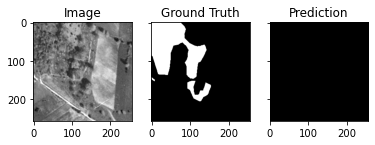

 11%|████▊                                       | 6/55 [00:06<00:41,  1.18it/s]

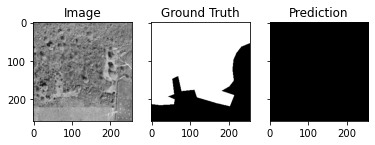

 13%|█████▌                                      | 7/55 [00:06<00:39,  1.20it/s]

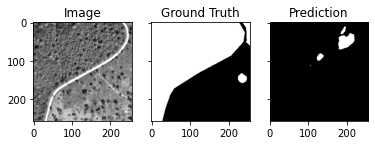

 15%|██████▍                                     | 8/55 [00:07<00:37,  1.25it/s]

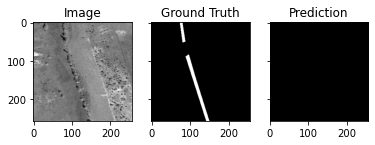

 16%|███████▏                                    | 9/55 [00:08<00:35,  1.30it/s]

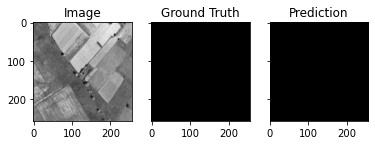

 18%|███████▊                                   | 10/55 [00:08<00:32,  1.40it/s]

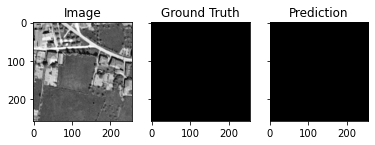

 20%|████████▌                                  | 11/55 [00:09<00:30,  1.45it/s]

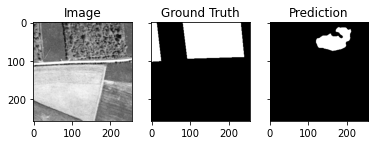

 22%|█████████▍                                 | 12/55 [00:10<00:30,  1.42it/s]

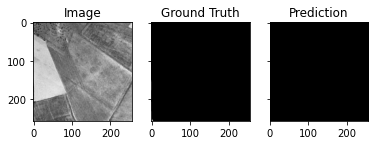

 24%|██████████▏                                | 13/55 [00:10<00:28,  1.47it/s]

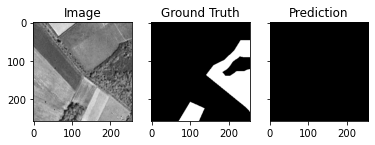

 25%|██████████▉                                | 14/55 [00:11<00:29,  1.38it/s]

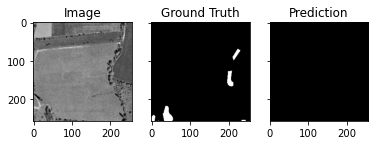

 27%|███████████▋                               | 15/55 [00:12<00:28,  1.39it/s]

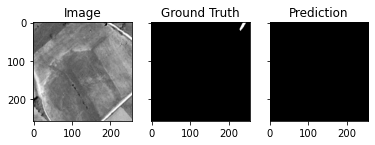

 29%|████████████▌                              | 16/55 [00:13<00:27,  1.40it/s]

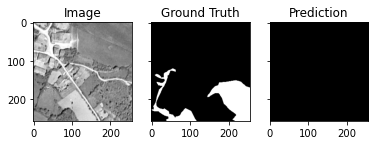

 31%|█████████████▎                             | 17/55 [00:13<00:28,  1.35it/s]

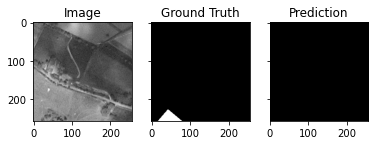

 33%|██████████████                             | 18/55 [00:14<00:26,  1.41it/s]

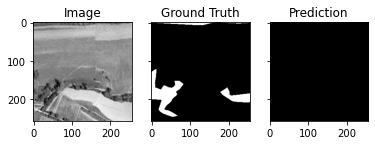

 35%|██████████████▊                            | 19/55 [00:15<00:24,  1.45it/s]

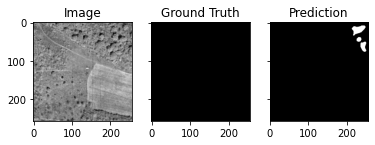

 36%|███████████████▋                           | 20/55 [00:15<00:24,  1.45it/s]

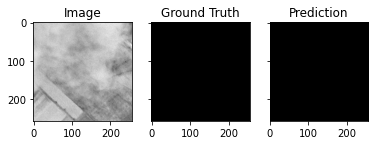

 38%|████████████████▍                          | 21/55 [00:16<00:23,  1.47it/s]

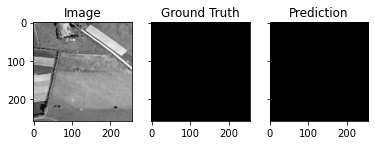

 40%|█████████████████▏                         | 22/55 [00:17<00:21,  1.55it/s]

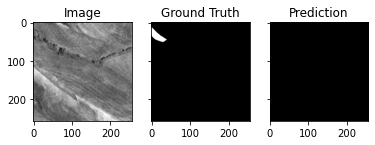

 42%|█████████████████▉                         | 23/55 [00:18<00:24,  1.32it/s]

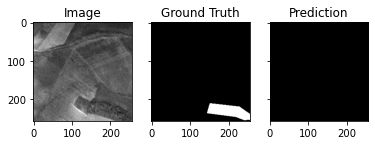

 44%|██████████████████▊                        | 24/55 [00:19<00:24,  1.26it/s]

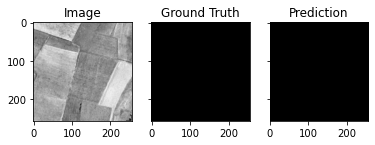

 45%|███████████████████▌                       | 25/55 [00:19<00:23,  1.30it/s]

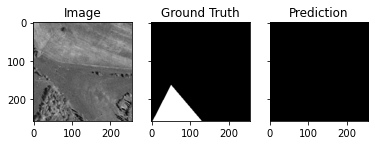

 47%|████████████████████▎                      | 26/55 [00:20<00:22,  1.29it/s]

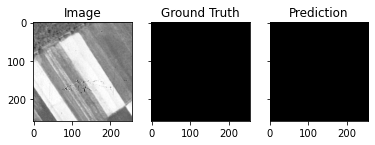

 49%|█████████████████████                      | 27/55 [00:21<00:20,  1.35it/s]

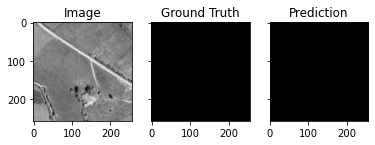

 51%|█████████████████████▉                     | 28/55 [00:21<00:20,  1.33it/s]

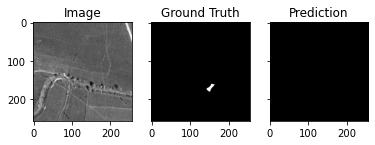

 53%|██████████████████████▋                    | 29/55 [00:22<00:19,  1.36it/s]

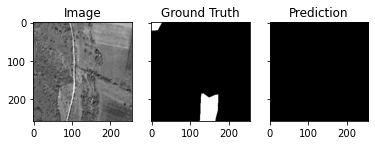

 55%|███████████████████████▍                   | 30/55 [00:23<00:18,  1.39it/s]

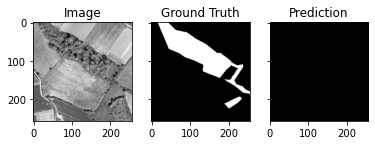

 56%|████████████████████████▏                  | 31/55 [00:24<00:22,  1.04it/s]

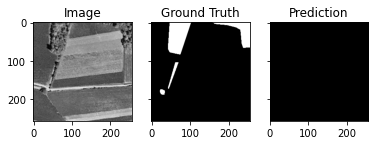

 58%|█████████████████████████                  | 32/55 [00:25<00:22,  1.04it/s]

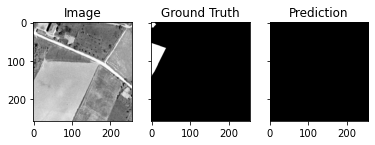

 60%|█████████████████████████▊                 | 33/55 [00:27<00:23,  1.06s/it]

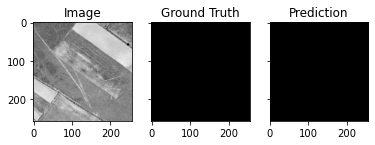

 62%|██████████████████████████▌                | 34/55 [00:27<00:20,  1.02it/s]

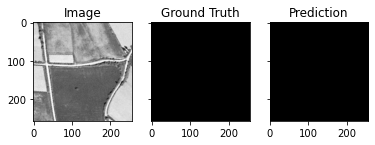

 64%|███████████████████████████▎               | 35/55 [00:29<00:22,  1.15s/it]

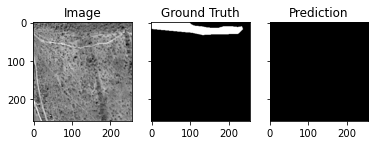

 65%|████████████████████████████▏              | 36/55 [00:30<00:20,  1.08s/it]

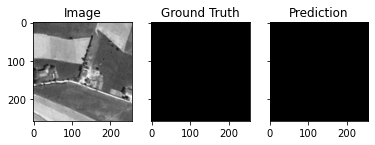

 67%|████████████████████████████▉              | 37/55 [00:31<00:19,  1.08s/it]

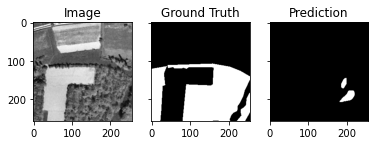

 69%|█████████████████████████████▋             | 38/55 [00:32<00:18,  1.07s/it]

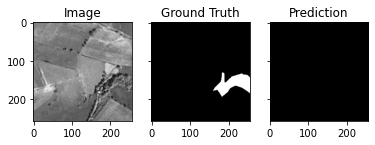

 71%|██████████████████████████████▍            | 39/55 [00:33<00:17,  1.09s/it]

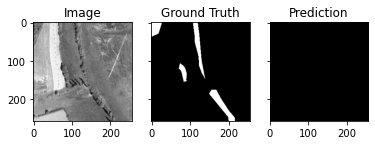

 73%|███████████████████████████████▎           | 40/55 [00:34<00:14,  1.00it/s]

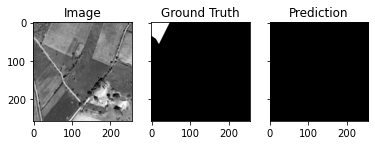

 75%|████████████████████████████████           | 41/55 [00:35<00:13,  1.03it/s]

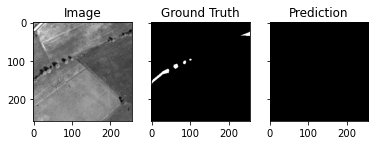

 76%|████████████████████████████████▊          | 42/55 [00:36<00:13,  1.08s/it]

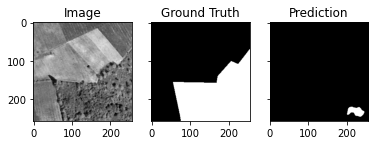

 78%|█████████████████████████████████▌         | 43/55 [00:37<00:11,  1.03it/s]

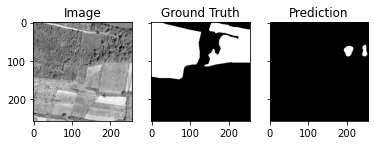

 80%|██████████████████████████████████▍        | 44/55 [00:38<00:10,  1.06it/s]

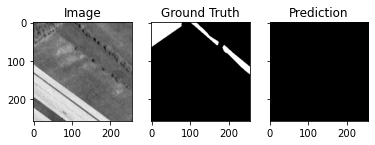

 82%|███████████████████████████████████▏       | 45/55 [00:39<00:09,  1.07it/s]

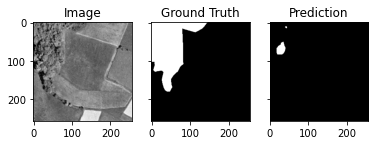

 84%|███████████████████████████████████▉       | 46/55 [00:40<00:09,  1.08s/it]

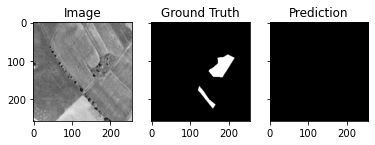

 85%|████████████████████████████████████▋      | 47/55 [00:42<00:10,  1.26s/it]

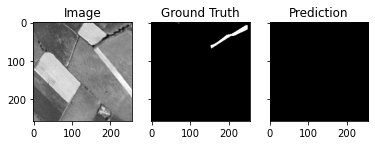

 87%|█████████████████████████████████████▌     | 48/55 [00:43<00:09,  1.34s/it]

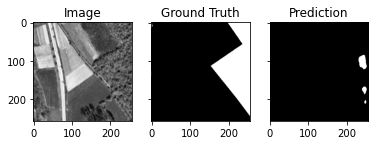

 89%|██████████████████████████████████████▎    | 49/55 [00:45<00:09,  1.52s/it]

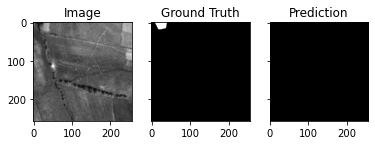

 91%|███████████████████████████████████████    | 50/55 [00:47<00:07,  1.46s/it]

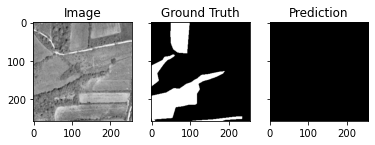

 93%|███████████████████████████████████████▊   | 51/55 [00:48<00:05,  1.45s/it]

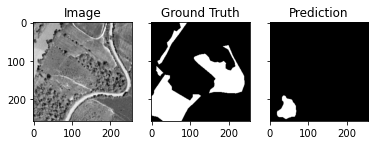

 95%|████████████████████████████████████████▋  | 52/55 [00:50<00:04,  1.51s/it]

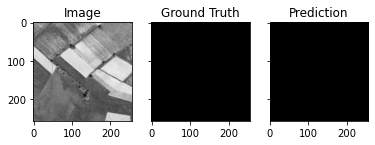

 96%|█████████████████████████████████████████▍ | 53/55 [00:51<00:02,  1.48s/it]

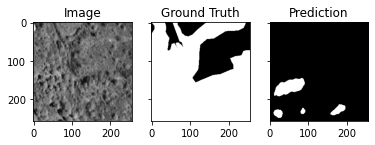

 98%|██████████████████████████████████████████▏| 54/55 [00:53<00:01,  1.56s/it]

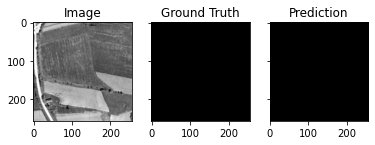

In [5]:
def save_predictions_as_imgs():
    # test dataloader
    pass

# load the model 
# Initialize our model
unet = model.unet_model.to(config.DEVICE)
path_model = '../best_model/best_model_epoch_4_acc_0.985_iou_0.003.pth' 
unet.load_state_dict(torch.load(path_model))
folder = '../saved_images' 

y_hat_test = []
y_true_test = []

# switch off autograd
with torch.no_grad():
    # set the model in evaluation mode
    unet.eval()

    # loop over the validation set
    loop = tqdm(test_dataloader, leave=False)

    for idx, (x_test, y_test) in enumerate(loop):
        # send the input to the device
        (x_test, y_test)  = (x_test.to(config.DEVICE), y_test.to(config.DEVICE))

        # Predictions
        pred_test = unet(x_test)

        # Assign appropriate class # ASK SEBASTIAN
        pred_test = pred_test.sigmoid()
        pred_test = (pred_test > 0.5).float()

        # Storing predictions and true labels 
        y_hat_test.append(pred_test)
        y_true_test.append(y_test)

        # metrics
        utis.plot_comparison(x_test, pred_test, y_test)

        # Save images
        # save_image(pred_test, f"{folder}/pred_{idx}.png") 
        # save_image(y_test, f"{folder}/y_true_{idx}.png")

# # Stack and flatten for confusion matrix # GETTING SIZE ERROR AT THE MOMENT
# torch.stack(y_hat_test).flatten()
# torch.stack(y_true_test).flatten()

In [33]:
y_hat_test[0].detach().cpu()

tensor([0., 1.])

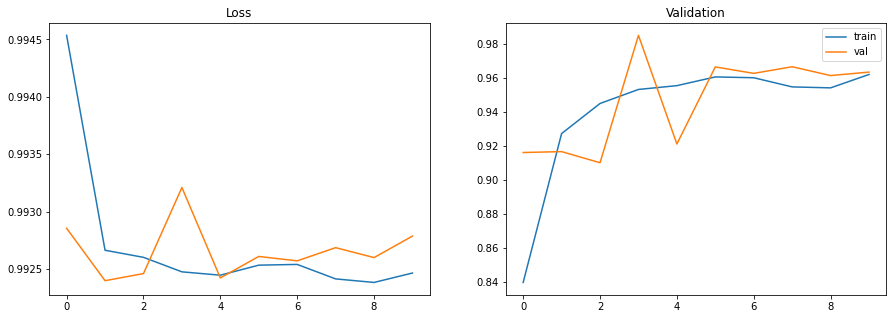

In [11]:
_, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(training_history['avg_train_loss'], label= 'train')
ax[0].plot(validation_history['avg_val_loss'], label='val')
ax[0].set_title('Loss')
ax[1].plot(training_history['train_accuracy'], label= 'train')
ax[1].plot(validation_history['val_accuracy'], label='val')
ax[1].set_title('Validation')
ax[1].legend()
plt.show()